# Forsterite Stagnation - release curve

Erik Davies - 03/20/2020

This script loads in an eos and calculates a decompression isentrope from a given shockstate until intersection with the l-v dome.

Complimenting the EOS is a decompression isentrope using the Thomas et al. 2013 liquid isentrope + the Davies et al. 2020 gruneisen parameter, and Root et al. 2018 principal hugoniot.

These curves do not include uncertainty as I am extrapolating to conditions well below their intended pressure and density ranges, as such any bounds on uncertainty cannot be relied upon. These calculations are meant to build intuition and be compared to data. They are not meant to make meaningful predictions.


Order of operations
1. Load in ANEOS isentrope
2. Load in thomas-davies isentrope parameters
3. from a single shock state, compare ANEOS, isentrope, and data

In [1]:
#User parameter inputs
#Simple user inputs, nothing else should need changing
#Shock state
#Enotropy value of the release isentrope - should match exp shock state
S_cho=4000 #J/K/kg

#Load in shock state params

#Set up array size for later on vapor fraction calculation
size=10000


User inputs will eventually be replaced by a spreadsheet containing stagnation data to compare to.
As of 03/20/2020, simply input an example shock and release state.

In [2]:
#Check and record versions
import platform
print('python version: ',platform.python_version())
del platform
import matplotlib
print('matplotlib version: ', matplotlib.__version__)
del matplotlib
import numpy
print('numpy version: ', numpy.__version__)
del numpy
import scipy
print('scipy version: ', scipy.__version__)
del scipy
import pandas
print('pandas version: ', pandas.__version__)
del pandas

python version:  3.6.4
matplotlib version:  2.2.0rc1
numpy version:  1.18.1
scipy version:  1.4.1
pandas version:  1.0.1


In [3]:
# this prevents some error messages for inline plotting in a jupyter notebook
%matplotlib inline 
# import python libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from copy import deepcopy
import numpy as np
import scipy.integrate as integrate
import scipy.interpolate as interpolate
import colormaps as local_cmaps
import subprocess
import pandas as pd
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
import scipy as sp
import statistics as stat
from matplotlib import rc
import eostable as eos
#

In [4]:

########Plot Parameters begin############3
#These control font size in plots.
params = {'legend.fontsize': 12,
         'axes.labelsize': 12,
         'axes.titlesize':12,
         'xtick.labelsize':12,
         'ytick.labelsize':10}
from cycler import cycler
plt.rcParams['axes.prop_cycle'] = cycler(color='bgrcmyk')
plt.rcParams.update(params)
plt.rcParams['xtick.major.size'] = 4
plt.rcParams['xtick.major.width'] = 0.5
plt.rcParams['xtick.minor.size'] = 2
plt.rcParams['xtick.minor.width'] = 0.5
plt.rcParams['ytick.major.size'] = 4
plt.rcParams['ytick.major.width'] = 0.5
plt.rcParams['ytick.minor.size'] = 2
plt.rcParams['ytick.minor.width'] = 0.5
plt.rcParams['axes.linewidth']= 1

plt.rcParams['lines.linewidth'] = 1.0
plt.rcParams['lines.dashed_pattern'] = [6, 6]
plt.rcParams['lines.dashdot_pattern'] = [3, 5, 1, 5]
plt.rcParams['lines.dotted_pattern'] = [1, 3]
plt.rcParams['errorbar.capsize'] = 3
plt.rcParams['lines.scale_dashes'] = False
plt.rcParams['legend.fancybox'] = False
plt.rcParams['legend.framealpha'] = None
plt.rcParams['legend.edgecolor'] = 'inherit'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 100

plt.rcParams['mathtext.rm'] = 'serif'
plt.rcParams['font.family']='Times New Roman'
plt.rcParams["figure.figsize"] = (5,4)
plt.rcParams["patch.force_edgecolor"] = True

########Plot Parameters finish############3


In [5]:
#Load in model

MODELNAME = 'Forsterite-ANEOS-SLVTv1.0G1'
# read EOS table      
forstEOS = eos.extGADtable()
forstEOS.readStdGadget('NEW-GADGET-STD-NOTENSION.TXT') # reads P-V-T-S-U-cs
forsthug = eos.EOShugoniot()
forsthug.T=np.loadtxt('NEW-SESAME-HUG.TXT',delimiter=',',skiprows=3,usecols=[0]) # K
forsthug.rho=np.loadtxt('NEW-SESAME-HUG.TXT',delimiter=',',skiprows=3,usecols=[1]) * 1000 # To kg/m^3
forsthug.P=np.loadtxt('NEW-SESAME-HUG.TXT',delimiter=',',skiprows=3,usecols=[2]) # Gpa
forsthug.U=np.loadtxt('NEW-SESAME-HUG.TXT',delimiter=',',skiprows=3,usecols=[3]) # MJ/kg
forsthug.S=np.loadtxt('NEW-SESAME-HUG.TXT',delimiter=',',skiprows=3,usecols=[4]) *(10**6) # J/K/kg
forsthug.up=np.loadtxt('NEW-SESAME-HUG.TXT',delimiter=',',skiprows=3,usecols=[5]) #km/s
forsthug.us=np.loadtxt('NEW-SESAME-HUG.TXT',delimiter=',',skiprows=3,usecols=[6]) #km/s



#Units are in CGS so replace with SI
#S is in erg/K/g
forstEOS.S=forstEOS.S *(10**(-4)) #J/K/kg
# rho is g/cm^3
forstEOS.rho=forstEOS.rho *(10**(3)) #kg/m^3
#P is dynes/cm2
forstEOS.P=forstEOS.P *(10**(-10))#GPa
#T is K, do nothing
#Cs, sound sped is cm/s
forstEOS.cs=forstEOS.cs *(10**(-5)) 

In [6]:
#More model stuff - taken from forsterite_aneos.ipynb
# ====>>>>>> YOU NEED TO MAKE SURE THESE VALUES MATCH ANEOS.INPUT  <<<<=====
MODELNAME = 'Forsterite-ANEOS-SLVTv1.0G1'
# Header information must all be compatible with float format
MATID = 1.0        # MATID number
DATE = 190802.     # Date as a single 6-digit number YYMMDD
VERSION = 0.1      # ANEOS Parameters Version number
FMN = 70.          # Formula weight in atomic numbers for Mg2SiO4
FMW = 140.691      # Formula molecular weight (g/cm3) for Mg2SiO4
# The following define the default initial state for material in the 201 table
R0REF   = 3.22     # g/cm3 *** R0REF is inserted into the density array
K0REF   = 1.1E12   # dynes/cm2
T0REF   = 298.     # K -- *** T0REF is inserted into the temperature array
P0REF   = 1.E6     # dynes/cm2 -- this defines the principal Hugoniot calculated below
#
# generate output files for other ANEOS models
modelflag = 0   # 0 - don't change anything above; 1 - Canup et al. 2013; 
                # 2 - GADGET2 Marcus PhD Thesis & Cuk & Stewart 2012; 3 - ISALE Dellen Collins and Melosh 2014
#

# READ IN NEW ANEOS MODEL and fill the extEOStable class object
# source in eostable.py
#------------------------------------------------------------------
NewEOS  = eos.extEOStable() # FIRST make new empty EOS object
NewEOS.loadextsesame('NEW-SESAME-EXT.TXT') # LOAD THE EXTENDED 301 SESAME FILE GENERATED BY STSM VERSION OF ANEOS
NewEOS.loadstdsesame('NEW-SESAME-STD.TXT') # LOAD THE STANDARD 301 SESAME FILE GENERATED BY STSM VERSION OF ANEOS
NewEOS.MODELNAME = MODELNAME # string set above in user input
NewEOS.MDQ = np.zeros((NewEOS.NT,NewEOS.ND)) # makes the empty MDQ array
#print(NewEOS.units) # these are the default units for SESAME rho-T tables
#'Units: g/cm3, K, GPa, MJ/kg, MJ/kg, MJ/K/kg, cm/s, MJ/K/kg, KPA flag. 2D arrays are (NT,ND).'

# Add the header info to the table. This could be done during the loading. 
# if made from this notebook, these values are set in the user-input above.
# ** MAKE SURE THEY MATCH ANEOS.INPUT **
NewEOS.MATID   = MATID
NewEOS.DATE    = DATE
NewEOS.VERSION = VERSION
NewEOS.FMN     = FMN
NewEOS.FMW     = FMW
NewEOS.R0REF   = R0REF
NewEOS.K0REF   = K0REF
NewEOS.T0REF   = T0REF
NewEOS.P0REF   = P0REF
#
# Load the information from ANEOS.INPUT and ANEOS.OUTPUT
NewEOS.loadaneos(aneosinfname='ANEOS.INPUT',aneosoutfname='ANEOS.OUTPUT')

Done loading ANEOS files.
ANEOS WAS CALLED WITH THE FOLLOWING INPUT, LOADED FROM FILE  ANEOS.INPUT
 *         EOS#      string for EOS name           .....Hugoniot initial........ long
 *                                                 T(eV)           Rho(g/cc)     flag
 * Reference solid Hugoniot at STP initial density and temperature
 ANEOS1    -1        'Forsterite STS SLVTv1.0'     THUG=0.02568    RHUG=3.22     LONG

 *
 *         nelem     type      rho0      temp0(K)  press0    B0/-Cbulk Gamma0    Tdebye(K)
 *         V01       V02       V03       V04       V05       V06       V07       V08
 ANEOS2    3         4         3.22      298.      1.e6      1.10E12   0.65      -1300.

 *         TG model  Gamma     Esep      Tmelt(K)  ..Critical Pt..     Thermal Conduction
 *         or S1     3*C24     erg/g     or -Em    C53       C54       H0        C41
 *         V09       V10       V11       V12       V13       V14       V15       V16
 ANEOS3    -1        7.5       1.70E11   2163. 

Now that ANEOS is loaded in, load in parameters for the Birch-Murnaghan EOS using Thomas and Asimow 2013 parameters, the Davies et al. 2020 Gruneisen fit, and  the Root et al. 2018 principal shock hugoniot.

First, Pull 7000 K isotherm, release isentropes for various entropies, and phase boundaries for plotting.

In [9]:
#Find shock state, and eos index for given entropy
#Indices for shock and intersection of the L-V dome
#First entropy index
Si_min=min(min(np.where(S_cho<forstEOS.S)))
Si_max=max(min(np.where(S_cho>forstEOS.S)))
temp1=abs(forstEOS.S[Si_min]-S_cho)
temp2=abs(forstEOS.S[Si_max]-S_cho)
S_ind=Si_min #Set index to first one
if temp1 > temp2: #if temp2 is smaller use that one instead
    S_ind=Si_max

#Same as above except for hugoniot index
Si_min=min(min(np.where(S_cho<forsthug.S)))
Si_max=max(min(np.where(S_cho>forsthug.S)))
temp1=abs(forsthug.S[Si_min]-S_cho)
temp2=abs(forsthug.S[Si_max]-S_cho)
Sh_ind=Si_min #Set index to first one
if temp1 > temp2: #if temp2 is smaller use that one instead
    Sh_ind=Si_max

#Similar to above, finding peak pressure index of eos # i may not need this one.
Pi_max=max(min(np.where(forsthug.P[Sh_ind]>forstEOS.P[S_ind,:])))
P_ind=Pi_max #Set index to first one

#Also find L-V intersection of isentrope

if S_cho < NewEOS.cp.S*(10**6):
    print('got to s_cho less than CP')
    Si_min=min(min(np.where(S_cho>NewEOS.vc.Sl*(10**6))))
    Si_max=max(min(np.where(S_cho<NewEOS.vc.Sl*(10**6))))
    temp1=abs(NewEOS.vc.Sl[Si_min]*(10**6)-S_cho)
    temp2=abs(NewEOS.vc.Sl[Si_max]*(10**6)-S_cho)
    Slv_ind=Si_min #Set index to first one
    if temp1 > temp2: #if temp2 is smaller use that one instead
        Slv_ind=Si_max
        lvFlag=0 #Set a flag for later
        
if S_cho > NewEOS.cp.S*(10**6):
    print('got to s_cho more than CP')
    Si_min=min(min(np.where(S_cho>NewEOS.vc.Sv*(10**6))))
    Si_max=max(min(np.where(S_cho<NewEOS.vc.Sv*(10**6))))
    temp1=abs(NewEOS.vc.Sv[Si_min]*(10**6)-S_cho)
    temp2=abs(NewEOS.vc.Sv[Si_max]*(10**6)-S_cho)
    Slv_ind=Si_min #Set index to first one
    if temp1 > temp2: #if temp2 is smaller use that one instead
        Slv_ind=Si_max
        lvFlag=1 #Set flag for later


#Print the Shock state
print('The Shock State for chosen entropy = ',S_cho,' J/K/kg')
print('Peak Pressure = ',forsthug.P[Sh_ind], ' GPa')
print('Peak Temperature = ',forsthug.T[Sh_ind], ' K')
print('Peak Density = ',forsthug.rho[Sh_ind], ' Kg/m^3')
print('Peak Shock Velocity = ',forsthug.us[Sh_ind], ' km/s')
print('Peak Particle Velocity = ',forsthug.up[Sh_ind], ' km/s')

#print(forstEOS.P[S_ind,P_ind])

got to s_cho less than CP
The Shock State for chosen entropy =  4000  J/K/kg
Peak Pressure =  236.3909  GPa
Peak Temperature =  5096.575  K
Peak Density =  5886.0  Kg/m^3
Peak Shock Velocity =  12.73114  km/s
Peak Particle Velocity =  5.766433  km/s


Now we can go and find the 7000 K isotherm.

In [26]:
T_indice = min(min(np.where(NewEOS.T > 6995)))
#print(T_indice)
#print(NewEOS.T[T_indice-1])
#print(NewEOS.rho)


So now plotting everything...

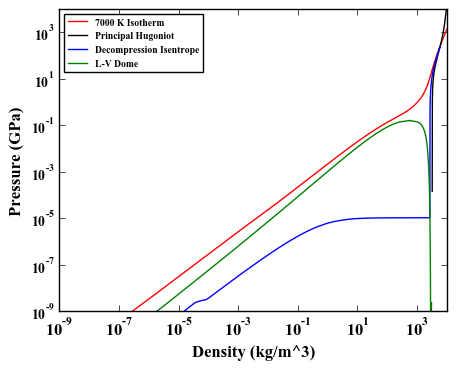

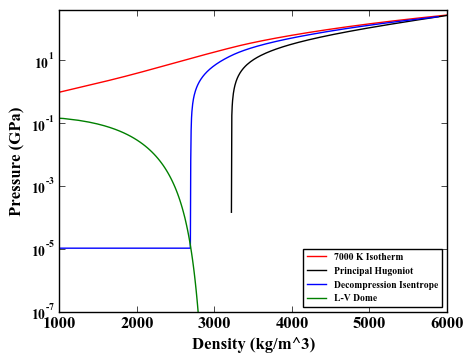

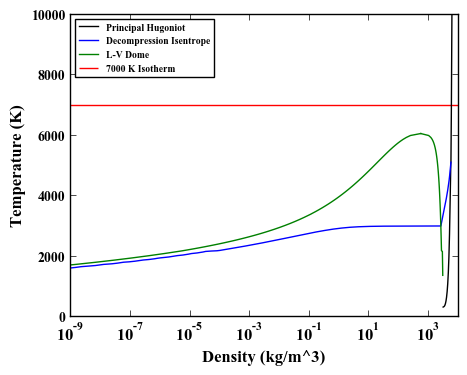

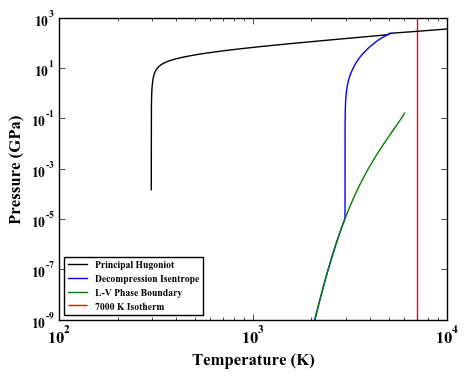

In [32]:
####EOS PLOTTING###


##P-rho###
plt.figure()
plt.plot(NewEOS.rho*1000,NewEOS.P[T_indice,:],color='red', label='7000 K Isotherm')
plt.plot(forsthug.rho,forsthug.P,'-',color='black',label='Principal Hugoniot')
plt.plot(forstEOS.rho[:P_ind+1],forstEOS.P[S_ind,:P_ind+1],'-',color='blue',label='Decompression Isentrope')
plt.plot(NewEOS.vc.rl*1000,NewEOS.vc.Pl,'-',color='green',label='L-V Dome')
plt.plot(NewEOS.vc.rv*1000,NewEOS.vc.Pv,'-',color='green')

plt.semilogy()
plt.semilogx()

plt.ylabel('Pressure (GPa)')
plt.xlabel('Density (kg/m^3)')
plt.legend(loc='best', fontsize='x-small',numpoints=1,scatterpoints=1)


#plt.xlim(0,20)
plt.ylim(10**(-9),10000)
plt.xlim(10**(-9),10000)
plt.savefig('P_Rho_decompression.pdf', format='pdf', dpi=1000)

##P-rho###
plt.figure()
plt.plot(NewEOS.rho*1000,NewEOS.P[T_indice,:],color='red', label='7000 K Isotherm')
plt.plot(forsthug.rho,forsthug.P,'-',color='black',label='Principal Hugoniot')
plt.plot(forstEOS.rho[:P_ind+1],forstEOS.P[S_ind,:P_ind+1],'-',color='blue',label='Decompression Isentrope')
plt.plot(NewEOS.vc.rl*1000,NewEOS.vc.Pl,'-',color='green',label='L-V Dome')
plt.plot(NewEOS.vc.rv*1000,NewEOS.vc.Pv,'-',color='green')

plt.semilogy()
#plt.semilogx()

plt.ylabel('Pressure (GPa)')
plt.xlabel('Density (kg/m^3)')
plt.legend(loc='best', fontsize='x-small',numpoints=1,scatterpoints=1)

#plt.xlim(0,20)
plt.ylim(10**(-7),400)
plt.xlim(1000,6000)
plt.savefig('P_Rho_decompression_lin.pdf', format='pdf', dpi=1000)

##/t-rho###
plt.figure()
plt.hlines(NewEOS.T[T_indice],10**(-9),10000,color='red', label='7000 K Isotherm')
plt.plot(forsthug.rho,forsthug.T,'-',color='black',label='Principal Hugoniot')
plt.plot(forstEOS.rho[:P_ind+1],forstEOS.T[S_ind,:P_ind+1],'-',color='blue',label='Decompression Isentrope')
plt.plot(NewEOS.vc.rl*1000,NewEOS.vc.T,'-',color='green',label='L-V Dome')
plt.plot(NewEOS.vc.rv*1000,NewEOS.vc.T,'-',color='green')

#plt.semilogy()
plt.semilogx()


plt.ylabel('Temperature (K)')
plt.xlabel('Density (kg/m^3)')
plt.legend(loc='best', fontsize='x-small',numpoints=1,scatterpoints=1)

#plt.xlim(0,20)
plt.ylim(0,10000)
plt.xlim(10**(-9),10000)
plt.savefig('T_Rho_decompression.pdf', format='pdf', dpi=1000)

##P-T###
plt.figure()
plt.plot(forsthug.T,forsthug.P,'-',color='black',label='Principal Hugoniot')
plt.plot(forstEOS.T[S_ind,:P_ind+1],forstEOS.P[S_ind,:P_ind+1],'-',color='blue',label='Decompression Isentrope')
plt.plot(NewEOS.vc.T,NewEOS.vc.Pv,'-',color='green',label='L-V Phase Boundary')
plt.vlines(NewEOS.T[T_indice],10**(-9),1000,color='red', label='7000 K Isotherm')
#NewEOS.vc.T

plt.semilogy()
plt.semilogx()

plt.ylabel('Pressure (GPa)')
plt.xlabel('Temperature (K)')
plt.legend(loc='best', fontsize='x-small',numpoints=1,scatterpoints=1)

plt.xlim(100,10000)
plt.ylim(10**(-9),1000)
plt.savefig('T_P_decompression.pdf', format='pdf', dpi=1000)


plt.show()

In [7]:
#The Birch-Murnaghan parameters

#Isentrope parameters for forsterite liquid
K0=16.41E9 #Pa, from Thomas and Asimow 2013, isentropic bulk modulus
K1=7.37 #dimensionless derivative of K0
cp=1926 #J/kg/K, heat capacity at contant pressure
cv=1715 #J/kg/K, heat capacity at contant volume
rho_0=2597 # kg/m^3, ref dens
T_0 = 2273 # K, ref temperature

#Some more constants
n=7 # Number of atoms in formula unit
R=8.314 # kg m^2/(s*K*mol) Gas constant
ma=140.6931 #(g/mol) molecular weight of forsterite
ma=ma/1000 # putting the previous into kg

T_amb=298.15 # K, ambient initial temperature
Tm=2174 # K, melting temperature
Pbar=100000 #pa, atmospheric pressure
rho0s=3220#kg/m3 initial density in solid

In [8]:
#Empirical Functions
#Root 2018 Hugoniot Us-Up - universal Hugoniot version (up index)
def hugoniot(a,b,c,x): 
    #return a2+b2*x2+c2*x2**2
    return a + b*x - c*x*np.exp(-d*x)
ah=6.89
bh=1.22
ch=1.5
dh=0.4

#Root 2018 Hugoniot Us-T (us index)
def temperature(a2,b2,c2,x2):
    #return a2+b2*x2+c2*x2**2
    return a2 * x2 + b2 * x2**2 + c2 * x2**3
a2r=-183.188 # T=a*x+b*x**2+c*x**3, for this us in km/s
b2r=15.60
c2r=2.785

#Davies 2020 Gamma fit
def gamma_fit(x,a,b,c,d,e): #fitting function for gamma values (density index)
    return 2/3 + (a - 2/3)*(2597/x)**b + c*np.exp((-(x-d)**2)/(e**2))\
#Gamma Paramters
A_mean=0.376568831195
B_mean=3.69951351528
C_mean=0.654310523784
D_mean=4928.94895961
E_mean=1195.83314527